# AI-Based Concrete Crack Detection using EfficientNetB0 and Grad-CAM

This notebook:
- Uses my own dataset archive (`archive (4).zip`) containing concrete crack images taken from Kaggle.
- Trains an EfficientNetB0-based classifier (Crack vs No Crack).
- Performs EDA and proper Train/Validation/Test splitting.
- Evaluates performance on a held-out test set.
- Visualizes model attention using Grad-CAM.
- Saves the trained model (`.h5`) for real-time webcam demo on my laptop.


In [1]:
!pip install -q kaggle opencv-python scikit-learn matplotlib tensorflow


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# Basic configuration
IMG_SIZE = (224, 224)   # EfficientNetB0 default
BATCH_SIZE = 32
EPOCHS = 10             # you can increase later (e.g. 15–20)
SEED = 42

base_dir = "/content/crack_project"
raw_dir = os.path.join(base_dir, "raw_data")
split_dir = os.path.join(base_dir, "data")

os.makedirs(base_dir, exist_ok=True)
os.makedirs(raw_dir, exist_ok=True)

print("Base dir:", base_dir)


TensorFlow version: 2.20.0
Base dir: /content/crack_project


In [3]:
import os
import zipfile
import shutil

# 1️⃣ Set correct local ZIP path
zip_path = r"C:\Users\Hitarth Khatiwala\OneDrive\Desktop\archived.zip"

# 2️⃣ Extract ZIP into dataset/
extract_dir = "dataset"

if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted Folders:", os.listdir(extract_dir))

# 3️⃣ Direct fixed paths (NO autodetection, NO raw_dir)
pos_dir = r"dataset\Positive"
neg_dir = r"dataset\Negative"

# 4️⃣ Validate folders
if not os.path.exists(pos_dir):
    raise RuntimeError("ERROR: 'Positive' folder NOT found.")

if not os.path.exists(neg_dir):
    raise RuntimeError("ERROR: 'Negative' folder NOT found.")

# 5️⃣ Print dataset info
print("Positive folder:", pos_dir)
print("Negative folder:", neg_dir)

print("Positive images:", len(os.listdir(pos_dir)))
print("Negative images:", len(os.listdir(neg_dir)))



Extracted Folders: ['Negative', 'Positive']
Positive folder: dataset\Positive
Negative folder: dataset\Negative
Positive images: 20000
Negative images: 20000


Number of CRACK images: 20000
Number of NO-CRACK images: 20000


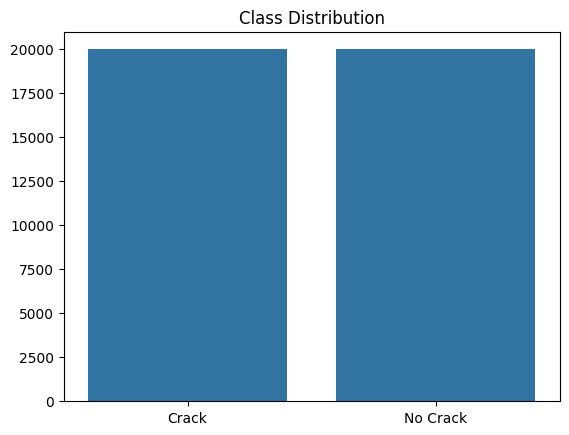

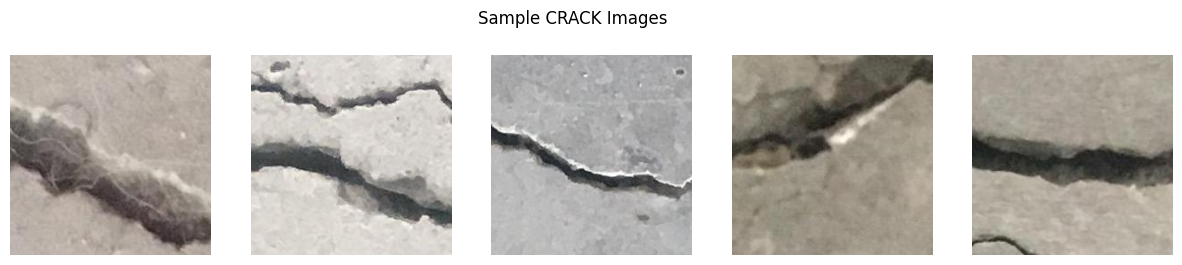

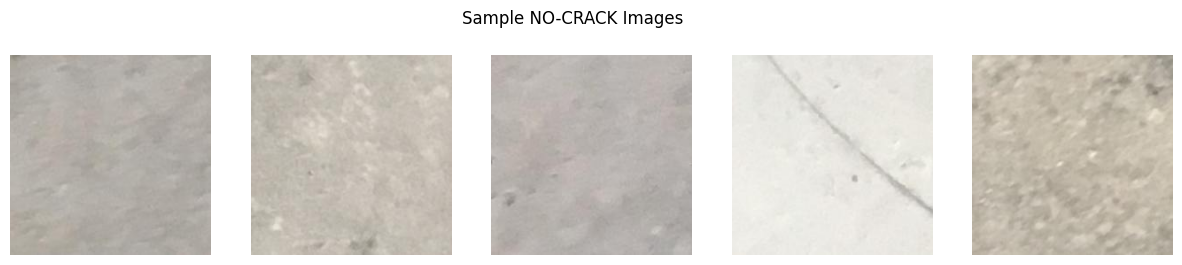

In [4]:
pos_images = [os.path.join(pos_dir, f) for f in os.listdir(pos_dir)]
neg_images = [os.path.join(neg_dir, f) for f in os.listdir(neg_dir)]

print("Number of CRACK images:", len(pos_images))
print("Number of NO-CRACK images:", len(neg_images))

# Class distribution barplot
sns.barplot(x=["Crack", "No Crack"], y=[len(pos_images), len(neg_images)])
plt.title("Class Distribution")
plt.show()

def show_random_images(folder, title, n=5):
    files = os.listdir(folder)
    samples = random.sample(files, min(n, len(files)))
    plt.figure(figsize=(15,3))
    for i, fname in enumerate(samples):
        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_random_images(pos_dir, "Sample CRACK Images")
show_random_images(neg_dir, "Sample NO-CRACK Images")


In [5]:
import shutil

# Create split directories
for split in ["train", "val", "test"]:
    for cls in ["crack", "no_crack"]:
        os.makedirs(os.path.join(split_dir, split, cls), exist_ok=True)

# Build dataframe of file paths + labels
files = pos_images + neg_images
labels = [1]*len(pos_images) + [0]*len(neg_images)  # 1 = crack, 0 = no_crack

df = pd.DataFrame({"path": files, "label": labels})
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle

# 70 / 15 / 15 stratified split
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.17647, stratify=train_val_df["label"], random_state=SEED
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

def copy_df_to_folder(df, split_name):
    for _, row in df.iterrows():
        src = row["path"]
        label = "crack" if row["label"] == 1 else "no_crack"
        dst = os.path.join(split_dir, split_name, label, os.path.basename(src))
        shutil.copy(src, dst)

copy_df_to_folder(train_df, "train")
copy_df_to_folder(val_df, "val")
copy_df_to_folder(test_df, "test")

for split in ["train", "val", "test"]:
    for cls in ["crack", "no_crack"]:
        d = os.path.join(split_dir, split, cls)
        print(split, cls, ":", len(os.listdir(d)))


Train: 28000 Val: 6000 Test: 6000
train crack : 14000
train no_crack : 14000
val crack : 3000
val no_crack : 3000
test crack : 3000
test no_crack : 3000


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = val_datagen.flow_from_directory(
    os.path.join(split_dir, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [7]:
# Build EfficientNetB0-based model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

# Freeze base model for initial training
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ efficientnetb0 (Functional)   │ (None, 7, 7, 1280)    │    4,049,571 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d      │ (None, 1280)          │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 1280)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │        1,281 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 942s 1s/step - accuracy: 0.9902 - loss: 0.0459 - val_accuracy: 0.9963 - val_loss: 0.0137
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 963s 1s/step - accuracy: 0.9968 - loss: 0.0116 - val_accuracy: 0.9968 - val_loss: 0.0092
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 987s 1s/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.9980 - val_loss: 0.0076
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 1010s 1s/step - accuracy: 0.9981 - loss: 0.0074 - val_accuracy: 0.9973 - val_loss: 0.0071
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 906s 1s/step - accuracy: 0.9976 - loss: 0.0071 - val_accuracy: 0.9980 - val_loss: 0.0066
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 917s 1s/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9982 - val_loss: 0.0058
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9983 - val_loss: 0.0054
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.9982 - loss: 0.0056 - val_acc

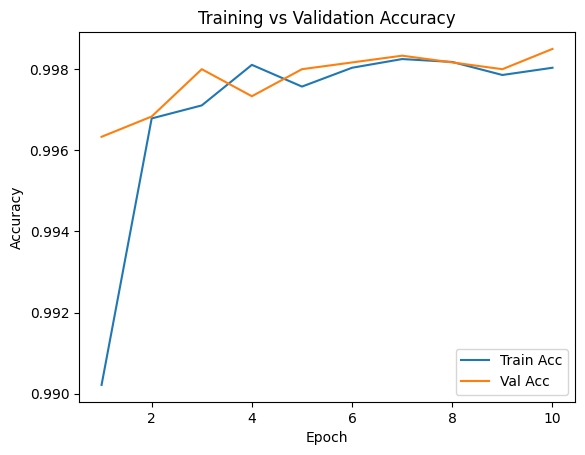

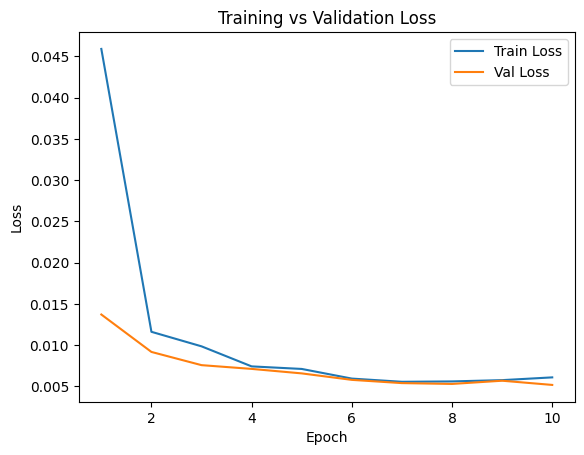

In [8]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1, len(acc)+1)

plt.figure()
plt.plot(epochs_range, acc, label="Train Acc")
plt.plot(epochs_range, val_acc, label="Val Acc")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 705ms/step
Classification Report:
              precision    recall  f1-score   support

    no_crack       1.00      1.00      1.00      3000
       crack       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



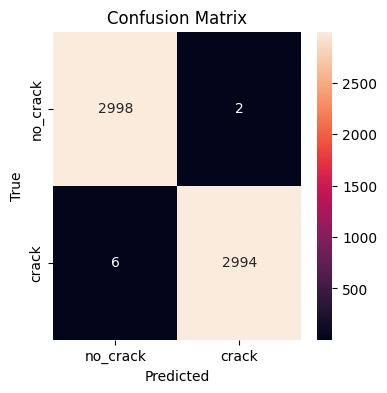

In [9]:
y_prob = model.predict(test_gen)
y_pred = (y_prob.ravel() >= 0.5).astype(int)
y_true = test_gen.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["no_crack", "crack"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["no_crack","crack"],
            yticklabels=["no_crack","crack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
model_path = "/content/crack_detector_efficientnetb0.h5"
model.save(model_path)
print("Saved model to:", model_path)


Saved model to: /content/crack_detector_efficientnetb0.h5


GRAD CAM CREATION FOR UNDERSTANDING THE WORKING OF THE MODEL!!!

In [11]:
import tensorflow as tf

# Get the EfficientNet base from your main model
base_model = model.get_layer("efficientnetb0")
print("Base model name:", base_model.name)

# Get the head layers from your main model
gap_layer = model.get_layer("global_average_pooling2d")
dropout_layer = model.get_layer("dropout")
dense_layer = model.get_layer("dense")

print("Head layers:", gap_layer.name, dropout_layer.name, dense_layer.name)


Base model name: efficientnetb0
Head layers: global_average_pooling2d dropout dense


In [12]:
print(train_gen.class_indices)


{'crack': 0, 'no_crack': 1}


In [13]:
def make_gradcam_heatmap(img_array):
    """
    img_array: shape (1, H, W, 3)
    - already preprocessed with preprocess_input
    - We compute Grad-CAM for the CRACK class.
    """

    img_tensor = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        # Forward pass through EfficientNetB0
        features = base_model(img_tensor, training=False)   # (1, 7, 7, 1280)

        # Forward pass through head: GAP -> Dropout -> Dense
        x = gap_layer(features)
        x = dropout_layer(x, training=False)
        preds = dense_layer(x)                              # (1, 1)

        # Model output is P(no_crack) because class 1 = 'no_crack'
        prob_no_crack = preds[:, 0]
        prob_crack = 1.0 - prob_no_crack                   # we want CRACK

    # Gradients of P(crack) w.r.t feature maps
    grads = tape.gradient(prob_crack, features)            # (1, 7, 7, 1280)

    # Global average pooling over H,W -> importance per channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))   # (1280,)

    # Remove batch dimension
    features = features[0]                                 # (7, 7, 1280)

    # Weight each channel by importance
    weighted_features = features * pooled_grads

    # Average over channels to get 2D heatmap
    heatmap = tf.reduce_mean(weighted_features, axis=-1)   # (7, 7)

    # ReLU + normalize
    heatmap = tf.nn.relu(heatmap)
    max_val = tf.reduce_max(heatmap)
    heatmap = heatmap / (max_val + 1e-8)

    return heatmap.numpy()



def overlay_heatmap_on_image(orig_img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    orig_img: RGB uint8 image of shape (H, W, 3)
    heatmap:  2D float array in [0, 1]
    """
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)

    # Apply colormap (JET) and convert BGR->RGB
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(heatmap_color, alpha, orig_img, 1 - alpha, 0)
    return overlay


Using image: /content/crack_project\data\test\crack\10823_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: CRACK  [P(crack)=1.00, P(no_crack)=0.00]


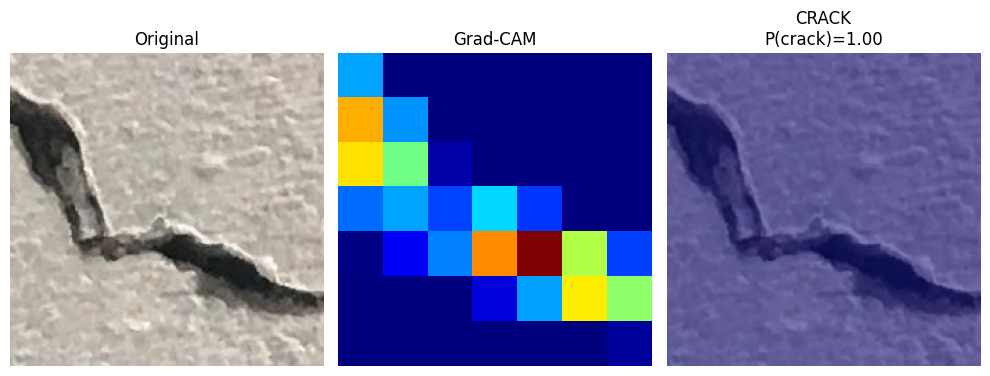

In [14]:

test_crack_dir = os.path.join(split_dir, "test", "crack")


fname = random.choice(os.listdir(test_crack_dir))
img_path = os.path.join(test_crack_dir, fname)
print("Using image:", img_path)


orig_bgr = cv2.imread(img_path)
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)


img_resized = cv2.resize(orig_rgb, IMG_SIZE)


img_array = np.expand_dims(img_resized.astype("float32"), axis=0)
img_preprocessed = preprocess_input(img_array.copy())


prob_no_crack = model.predict(img_preprocessed)[0][0]
prob_crack = 1.0 - prob_no_crack

label = "CRACK" if prob_crack >= 0.5 else "NO CRACK"
print(f"Prediction: {label}  [P(crack)={prob_crack:.2f}, P(no_crack)={prob_no_crack:.2f}]")


# Grad-CAM heatmap using our helper
heatmap = make_gradcam_heatmap(img_preprocessed)

# Overlay heatmap on the resized image
overlay = overlay_heatmap_on_image(img_resized, heatmap, alpha=0.5)

# Show all three
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig_rgb)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Grad-CAM")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.axis("off")
plt.title(f"{label}\nP(crack)={prob_crack:.2f}")


plt.tight_layout()
plt.show()


In [15]:
model.summary()
base_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ efficientnetb0 (Functional)   │ (None, 7, 7, 1280)    │    4,049,571 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d      │ (None, 1280)          │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 1280)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │        1,281 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 4,053,416 (15.46 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2,564 (10.02 KB)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 224, 224, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ rescaling          │ (None, 224, 224, │         0 │ input_layer[0][… │
│ (Rescaling)        │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ normalization      │ (None, 224, 224, │         7 │ rescaling[0][0]  │
│ (Normalization)    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ rescaling_1        │ (None, 224, 224, │         0 │ normalization[0… │
│ (Rescaling)        │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_conv_pad      │ (None, 225, 225, │         0 │ rescaling_1[0][… │
│ (ZeroPadding2D)    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_conv (Conv2D) │ (None, 112, 112, │       864 │ stem_conv_pad[0… │
│                    │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_bn            │ (None, 112, 112, │       128 │ stem_conv[0][0]  │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ stem_activation    │ (None, 112, 112, │         0 │ stem_bn[0][0]    │
│ (Activation)       │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_dwconv     │ (None, 112, 112, │       288 │ stem_activation… │
│ (DepthwiseConv2D)  │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_bn         │ (None, 112, 112, │       128 │ block1a_dwconv[… │
│ (BatchNormalizati… │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_activation │ (None, 112, 112, │         0 │ block1a_bn[0][0] │
│ (Activation)       │ 32)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_se_squeeze │ (None, 32)       │         0 │ block1a_activat… │
│ (GlobalAveragePoo… │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_se_reshape │ (None, 1, 1, 32) │         0 │ block1a_se_sque… │
│ (Reshape)          │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_se_reduce  │ (None, 1, 1, 8)  │       264 │ block1a_se_resh… │
│ (Conv2D)           │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_se_expand  │ (None, 1, 1, 32) │       288 │ block1a_se_redu… │
│ (Conv2D)           │                  │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_se_excite  │ (None, 112, 112, │         0 │ block1a_activat… │
│ (Multiply)         │ 32)              │           │ block1a_se_expa… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_project_c… │ (None, 112, 112, │       512 │ block1a_se_exci… │
│ (Conv2D)           │ 16)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ block1a_project_bn │ (None, 112, 112, │        64 │ bloc

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale=1/255)

train_gen = gen.flow_from_directory(
    "dataset",
    class_mode='binary',
    target_size=(224,224)
)

print(train_gen.class_indices)


Found 40000 images belonging to 2 classes.
{'Negative': 0, 'Positive': 1}


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

model = tf.keras.models.load_model(
    r"C:\Users\Hitarth Khatiwala\OneDrive\Desktop\content\crack_detector_efficientnetb0.h5",
    compile=False
)

IMG_SIZE = 224

def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)   # FIX 1: Convert BGR → RGB
    img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img.astype("float32"))    # FIX 2: Use correct EfficientNet preprocessing
    img = np.expand_dims(img, axis=0)
    return img

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret: break

    input_img = preprocess_frame(frame)
    pred = model.predict(input_img)[0][0]

# Binary output: NO-CRACK (1) / CRACK (0)
    label = "NO CRACK" if pred > 0.5 else "CRACK"
    color = (0, 255, 0) if pred > 0.5 else (0, 0, 255)


    cv2.putText(frame, f"{label} ({pred:.2f})", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

    cv2.imshow("Crack Detection - LIVE", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'): break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━